In [25]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === Helper Function: process and average by country-year ===
def process_monthly_climate(filepath, variable_prefix, lookup_gdf):
    df = pd.read_csv(filepath)
    df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    gdf_proj = gdf.to_crs("EPSG:3857")
    lookup_proj = lookup_gdf.to_crs("EPSG:3857")
    joined = gpd.sjoin_nearest(gdf_proj, lookup_proj, how='left', distance_col='distance')
    joined = joined.to_crs("EPSG:4326").drop(columns='geometry')

    month_cols = [col for col in df.columns if 'month' in col.lower()]
    new_col_map = {col: f"{variable_prefix}_{i+1}" for i, col in enumerate(month_cols)}
    joined = joined.rename(columns=new_col_map)

    monthly_avg = joined.groupby(['country', 'year'])[[*new_col_map.values()]].mean().reset_index()
    return monthly_avg

# === Load lookup and yield data ===
lookup_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")
lookup_df['geometry'] = [Point(xy) for xy in zip(lookup_df['longitude'], lookup_df['latitude'])]
lookup_gdf = gpd.GeoDataFrame(lookup_df, geometry='geometry', crs='EPSG:4326')

yield_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Yield_and_Production_data.csv")
yield_df.columns = [c.strip().lower() for c in yield_df.columns]
yield_df = yield_df[yield_df["element"] == "Yield"]
if "yield" not in yield_df.columns and "value" in yield_df.columns:
    yield_df = yield_df.rename(columns={"value": "yield"})

# === Define all climate datasets (including CanopInt) ===
climate_files = {
    "rain": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv",
    "snow": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Snowf_tavg_data.csv",
    "esoil": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/ESoil_tavg_data.csv",
    "soilmoisture_0_10": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi0_10cm_inst_data.csv",
    "soilmoisture_10_40": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi10_40cm_inst_data.csv",
    "soilmoisture_40_100": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi40_100cm_inst_data.csv",
    "soilmoisture_100_200": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi100_200cm_inst_data.csv",
    "soiltemp_0_10": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP0_10cm_inst_data.csv",
    "soiltemp_10_40": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP10_40cm_inst_data.csv",
    "soiltemp_40_100": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP40_100cm_inst_data.csv",
    "soiltemp_100_200": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP100_200cm_inst_data.csv",
    "tveg": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/TVeg_tavg_data.csv",
    "tws": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/TWS_inst_data.csv",
    "canopint": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/CanopInt_inst_data.csv"  # Newly added dataset
}

# === Process and merge all climate datasets ===
merged_climate = None
for prefix, path in climate_files.items():
    climate_df = process_monthly_climate(path, prefix, lookup_gdf)
    if merged_climate is None:
        merged_climate = climate_df
    else:
        merged_climate = pd.merge(merged_climate, climate_df, on=["country", "year"], how="outer")

# === Process Land Cover Percent (annual, per country) ===
land_cover_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Land_Cover_Percent_data.csv")
land_cover_df['geometry'] = [Point(xy) for xy in zip(land_cover_df['longitude'], land_cover_df['latitude'])]
land_cover_gdf = gpd.GeoDataFrame(land_cover_df, geometry='geometry', crs='EPSG:4326')

land_cov_joined = gpd.sjoin_nearest(land_cover_gdf.to_crs("EPSG:3857"), lookup_gdf.to_crs("EPSG:3857"), how='left')
land_cov_joined = land_cov_joined.to_crs("EPSG:4326").drop(columns='geometry')

land_class_cols = [col for col in land_cover_df.columns if "class_" in col.lower()]
land_cov_col_map = {col: f"mean_cov_{col.split('_')[-1]}" for col in land_class_cols}
land_cov_joined = land_cov_joined.rename(columns=land_cov_col_map)

land_cov_summary = land_cov_joined.groupby("country")[list(land_cov_col_map.values())].mean().reset_index()

# === Merge with climate on country + year ===
climate_with_land = pd.merge(merged_climate, land_cov_summary, on="country", how="left")

# === Merge with yield data ===
final_df = pd.merge(yield_df, climate_with_land, on=["country", "year"], how="inner")

# === Organize column order ===
def ordered_columns(final_df):
    rain_cols = [f"rain_{i}" for i in range(1, 13)]
    snow_cols = [f"snow_{i}" for i in range(1, 13)]
    esoil_cols = [f"esoil_{i}" for i in range(1, 13)]
    soilm_cols, soilt_cols = [], []
    for layer in ["0_10", "10_40", "40_100", "100_200"]:
        soilm_cols += [f"soilmoisture_{layer}_{i}" for i in range(1, 13)]
        soilt_cols += [f"soiltemp_{layer}_{i}" for i in range(1, 13)]

    tveg_cols = [f"tveg_{i}" for i in range(1, 13)]
    tws_cols = [f"tws_{i}" for i in range(1, 13)]
    canopint_cols = [f"canopint_{i}" for i in range(1, 13)]
    landcov_cols = [f"mean_cov_{i}" for i in range(1, 18)]

    base_cols = ["country", "item", "year"]
    all_features = landcov_cols + rain_cols + snow_cols + esoil_cols + soilm_cols + soilt_cols + tveg_cols + tws_cols + canopint_cols
    all_features = [col for col in all_features if col in final_df.columns]

    return base_cols + all_features + ["yield"]

final_df = final_df[ordered_columns(final_df)]

# === Save final output ===
final_df.to_csv("V5_final_with_canopint.csv", index=False)

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("V5_final_with_canopint.csv")

# Create a helper group identifier using country + item
df['group'] = df['country'] + "_" + df['item']

# Get all unique (country_item) groups
unique_groups = df['group'].unique()

# First split: 80% train, 20% temp (eval + test)
train_groups, temp_groups = train_test_split(
    unique_groups, test_size=0.2, random_state=42
)

# Second split: temp into 50% eval, 50% test (=> each 10% of total)
eval_groups, test_groups = train_test_split(
    temp_groups, test_size=0.5, random_state=42
)

# Create final dataframes by filtering based on group membership
train_df = df[df['group'].isin(train_groups)].copy()
eval_df = df[df['group'].isin(eval_groups)].copy()
test_df = df[df['group'].isin(test_groups)].copy()

# Drop the helper group column
for d in [train_df, eval_df, test_df]:
    d.drop(columns='group', inplace=True)

# Done! You can now use train_df, eval_df, and test_df

In [ ]:
# # Drop any rows with NaN before scaling
# train_df = train_df.dropna()
# eval_df = eval_df.dropna()
# test_df = test_df.dropna()

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("V5_final_with_canopint.csv")

# Create group by country + item
df['group'] = df['country'] + "_" + df['item']
unique_groups = df['group'].unique()

# Split into train/eval/test by group
train_groups, temp_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)
eval_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create actual splits
train_df = df[df['group'].isin(train_groups)].copy()
eval_df = df[df['group'].isin(eval_groups)].copy()
test_df = df[df['group'].isin(test_groups)].copy()

# Drop helper column
for d in [train_df, eval_df, test_df]:
    d.drop(columns='group', inplace=True)

# ==== COLUMN SETUP ====

# Static: 17 columns after 'year'
static_cols = df.columns[3:20]

# Time series (monthly) columns
sequence_cols = [col for col in df.columns if any(str(m) in col for m in range(1, 13)) and col not in static_cols]

# Target
target_col = 'yield'

# ==== REMOVE NaNs BEFORE SCALING ====

# Combine all relevant columns for cleaning
all_feature_cols = list(static_cols) + sequence_cols + [target_col]

train_df = train_df.dropna(subset=all_feature_cols)
eval_df = eval_df.dropna(subset=all_feature_cols)
test_df = test_df.dropna(subset=all_feature_cols)

# ==== SCALING ====

# Fit scalers on clean train data only
static_scaler = MinMaxScaler().fit(train_df[static_cols])
sequence_scaler = MinMaxScaler().fit(train_df[sequence_cols])

# Transform splits
def preprocess_split(df_split):
    static_data = static_scaler.transform(df_split[static_cols])
    sequence_data = sequence_scaler.transform(df_split[sequence_cols])
    
    # Reshape sequence data to (samples, 12, features)
    n_seq_features = len(sequence_cols) // 12
    sequence_tensor = sequence_data.reshape((-1, 12, n_seq_features))
    
    # Yield target
    yield_target = df_split[target_col].values.reshape(-1, 1)
    
    return static_data, sequence_tensor, yield_target

# Run it
X_static_train, X_seq_train, y_train = preprocess_split(train_df)
X_static_eval, X_seq_eval, y_eval = preprocess_split(eval_df)
X_static_test, X_seq_test, y_test = preprocess_split(test_df)

# Check shapes
print("Static input shape:", X_static_train.shape)
print("Sequence input shape:", X_seq_train.shape)
print("Target shape:", y_train.shape)

Static input shape: (46032, 17)
Sequence input shape: (46032, 12, 14)
Target shape: (46032, 1)


In [31]:
import torch
import torch.nn as nn

class YieldLSTMModel(nn.Module):
    def __init__(self, static_input_dim, seq_input_dim, hidden_dim=128, lstm_layers=3, dropout=0.4):
        super(YieldLSTMModel, self).__init__()

        # === LSTM BRANCH ===
        self.lstm = nn.LSTM(
            input_size=seq_input_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # === STATIC BRANCH ===
        self.static_fc = nn.Sequential(
            nn.Linear(static_input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )

        # === COMBINED BRANCH ===
        self.combined_fc = nn.Sequential(
            nn.Linear(hidden_dim + 32, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, static_input, seq_input):
        lstm_out, _ = self.lstm(seq_input)
        lstm_last = lstm_out[:, -1, :]  # last timestep output

        static_out = self.static_fc(static_input)

        combined = torch.cat((lstm_last, static_out), dim=1)
        return self.combined_fc(combined)

Epoch 1/50 - Train MAE: 8818.98, Eval MAE: 10959.67
Epoch 2/50 - Train MAE: 7943.07, Eval MAE: 9945.03
Epoch 3/50 - Train MAE: 7350.96, Eval MAE: 9601.67
Epoch 4/50 - Train MAE: 7199.68, Eval MAE: 9493.91
Epoch 5/50 - Train MAE: 7155.12, Eval MAE: 9376.12
Epoch 6/50 - Train MAE: 7134.03, Eval MAE: 9380.78
Epoch 7/50 - Train MAE: 7119.26, Eval MAE: 9504.23
Epoch 8/50 - Train MAE: 7109.27, Eval MAE: 9354.24
Epoch 9/50 - Train MAE: 7104.40, Eval MAE: 9287.20
Epoch 10/50 - Train MAE: 7095.39, Eval MAE: 9298.78
Epoch 11/50 - Train MAE: 7094.78, Eval MAE: 9309.88
Epoch 12/50 - Train MAE: 7085.97, Eval MAE: 9288.14
Epoch 13/50 - Train MAE: 7086.40, Eval MAE: 9349.81
Epoch 14/50 - Train MAE: 7069.36, Eval MAE: 9280.16
Epoch 15/50 - Train MAE: 7069.90, Eval MAE: 9286.30
Epoch 16/50 - Train MAE: 7064.25, Eval MAE: 9237.13
Epoch 17/50 - Train MAE: 7062.91, Eval MAE: 9253.08
Epoch 18/50 - Train MAE: 7054.21, Eval MAE: 9283.25
Epoch 19/50 - Train MAE: 7059.36, Eval MAE: 9233.71
Epoch 20/50 - Train 

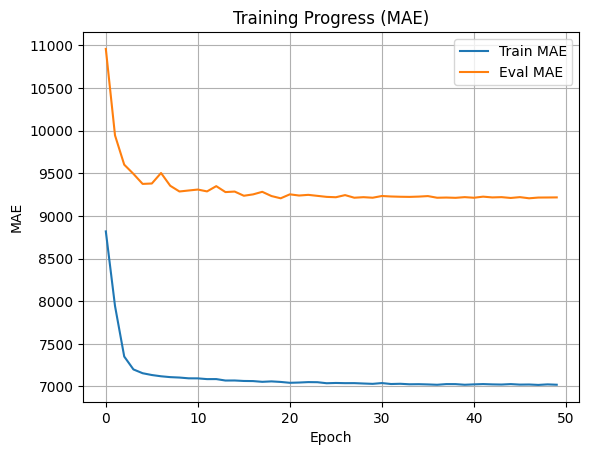

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Dataset class
class YieldDataset(Dataset):
    def __init__(self, static, sequence, target):
        self.static = torch.tensor(static, dtype=torch.float32)
        self.sequence = torch.tensor(sequence, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)
    
    def __len__(self):
        return len(self.static)
    
    def __getitem__(self, idx):
        return self.static[idx], self.sequence[idx], self.target[idx]

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(YieldDataset(X_static_train, X_seq_train, y_train), batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(YieldDataset(X_static_eval, X_seq_eval, y_eval), batch_size=batch_size)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your deeper model
model = YieldLSTMModel(
    static_input_dim=X_static_train.shape[1],
    seq_input_dim=X_seq_train.shape[2],
    hidden_dim=128,
    lstm_layers=3,
    dropout=0.4
).to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # <-- Weight decay added
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training loop
num_epochs = 50
train_losses = []
eval_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for static_x, seq_x, y in train_loader:
        static_x, seq_x, y = static_x.to(device), seq_x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(static_x, seq_x)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()

        total_train_loss += loss.item() * len(y)

    train_mae = total_train_loss / len(train_loader.dataset)
    train_losses.append(train_mae)

    # Evaluation
    model.eval()
    total_eval_loss = 0
    with torch.no_grad():
        for static_x, seq_x, y in eval_loader:
            static_x, seq_x, y = static_x.to(device), seq_x.to(device), y.to(device)
            output = model(static_x, seq_x)
            loss = criterion(output, y)
            total_eval_loss += loss.item() * len(y)

    eval_mae = total_eval_loss / len(eval_loader.dataset)
    eval_losses.append(eval_mae)

    scheduler.step(eval_mae)  # update learning rate based on eval MAE

    print(f"Epoch {epoch+1}/{num_epochs} - Train MAE: {train_mae:.2f}, Eval MAE: {eval_mae:.2f}")

# Plot MAE over epochs
plt.plot(train_losses, label="Train MAE")
plt.plot(eval_losses, label="Eval MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training Progress (MAE)")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from sklearn.preprocessing import MinMaxScaler

# Create and fit scaler only on training target
y_scaler = MinMaxScaler()
y_scaler.fit(train_df[['yield']])

MinMaxScaler()

In [36]:
def preprocess_split(df_split):
    static_data = static_scaler.transform(df_split[static_cols])
    sequence_data = sequence_scaler.transform(df_split[sequence_cols])
    
    # Reshape sequence data to (samples, 12, features)
    n_seq_features = len(sequence_cols) // 12
    sequence_tensor = sequence_data.reshape((-1, 12, n_seq_features))
    
    # Normalize yield using y_scaler
    yield_raw = df_split[['yield']].values
    yield_target = y_scaler.transform(yield_raw)
    
    return static_data, sequence_tensor, yield_target

In [37]:
# Create test DataLoader
test_loader = DataLoader(YieldDataset(X_static_test, X_seq_test, y_test), batch_size=128)

# Put model in eval mode
model.eval()

# Store predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for static_x, seq_x, y in test_loader:
        static_x, seq_x = static_x.to(device), seq_x.to(device)
        output = model(static_x, seq_x)

        all_preds.append(output.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Stack all batches into full arrays
y_pred_scaled = np.vstack(all_preds)
y_true_scaled = np.vstack(all_targets)

# Inverse transform (from normalized back to real-world units)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

# MAE on test set
test_mae = np.mean(np.abs(y_pred - y_true))
print(f"✅ Test MAE: {test_mae:.2f}")

✅ Test MAE: 2451985920.00


In [38]:
import random

indices = random.sample(range(len(y_pred)), 10)

for i in indices:
    print(f"Actual: {y_true[i][0]:.2f} — Predicted: {y_pred[i][0]:.2f}")

Actual: 306282816.00 — Predicted: 674659008.00
Actual: 469800416.00 — Predicted: 494243520.00
Actual: 1838932096.00 — Predicted: 1852531328.00
Actual: 2770596608.00 — Predicted: 1469553152.00
Actual: 1235260416.00 — Predicted: 2082835840.00
Actual: 446917184.00 — Predicted: 491184192.00
Actual: 247762352.00 — Predicted: 756007168.00
Actual: 13978299392.00 — Predicted: 1012391488.00
Actual: 205269408.00 — Predicted: 589286784.00
Actual: 2994919680.00 — Predicted: 1352286720.00


In [39]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

# Prepare DataLoader
test_loader = DataLoader(YieldDataset(X_static_test, X_seq_test, y_test), batch_size=128)

# Set model to eval
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for static_x, seq_x, y in test_loader:
        static_x, seq_x = static_x.to(device), seq_x.to(device)
        output = model(static_x, seq_x)

        all_preds.append(output.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Combine all batches
y_pred_scaled = np.vstack(all_preds)
y_true_scaled = np.vstack(all_targets)

# Inverse transform using your fitted scaler
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

# Reattach to metadata
test_meta = test_df.copy().reset_index(drop=True)
test_meta['actual_yield'] = y_true.flatten()
test_meta['predicted_yield'] = y_pred.flatten()

# Optional: Export to CSV
test_meta[['country', 'item', 'year', 'actual_yield', 'predicted_yield']].to_csv("predicted_test_yield.csv", index=False)

print("✅ Test predictions saved to 'predicted_test_yield.csv'")

✅ Test predictions saved to 'predicted_test_yield.csv'


In [40]:
# 1. Extract 2022 samples from the original full dataframe
test_2022_df = df[df['year'] == 2022].copy()

# 2. Drop rows with NaNs in relevant columns
needed_cols = list(static_cols) + sequence_cols + ['yield']
test_2022_df = test_2022_df.dropna(subset=needed_cols)

# 3. Preprocess inputs using previously fitted scalers
X_static_2022 = static_scaler.transform(test_2022_df[static_cols])
X_seq_2022 = sequence_scaler.transform(test_2022_df[sequence_cols])
n_seq_features = len(sequence_cols) // 12
X_seq_2022 = X_seq_2022.reshape((-1, 12, n_seq_features))

y_2022_raw = test_2022_df[['yield']].values
y_2022 = y_scaler.transform(y_2022_raw)

# 4. Create DataLoader
test_2022_loader = DataLoader(YieldDataset(X_static_2022, X_seq_2022, y_2022), batch_size=128)

# 5. Predict
model.eval()
all_preds_2022 = []

with torch.no_grad():
    for static_x, seq_x, _ in test_2022_loader:
        static_x, seq_x = static_x.to(device), seq_x.to(device)
        output = model(static_x, seq_x)
        all_preds_2022.append(output.cpu().numpy())

# 6. Inverse transform predictions
y_pred_2022_scaled = np.vstack(all_preds_2022)
y_pred_2022 = y_scaler.inverse_transform(y_pred_2022_scaled)
y_true_2022 = y_scaler.inverse_transform(y_2022)

# 7. Attach predictions to dataframe
test_2022_df = test_2022_df.reset_index(drop=True)
test_2022_df['actual_yield'] = y_true_2022.flatten()
test_2022_df['predicted_yield'] = y_pred_2022.flatten()

# 8. Save or return the result
test_2022_df[['country', 'item', 'year', 'actual_yield', 'predicted_yield']].to_csv("yield_predictions_2022.csv", index=False)
print("✅ Predictions for 2022 saved to 'yield_predictions_2022.csv'")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


✅ Predictions for 2022 saved to 'yield_predictions_2022.csv'
